In [30]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import AstroDataModule, Normalize, get_astro_data, get_astro_data_2D_from_3D, Stack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from torch.utils.data import Subset, random_split
import torch
from utils import compute_pk
from TF_utils import power_spectrum, getGrid
from torch import Tensor
torch.set_default_dtype(torch.float64)
device = torch.device("cuda")if torch.cuda.is_available() else "mps"

In [2]:
norm = Normalize('Astrid')
print(norm.mean_input_sims.device, norm.mean_target_sims.shape)

/global/u1/l/lindajin/camel_dataloader.py:184: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945388038/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.mean_input_sims =  torch.tensor([mass_cdm.mean(axis=(1,2))])


cpu torch.Size([1, 15000])


In [ ]:
one_batch = next(iter(dm_TF.test_dataloader()))
print(np.shape(one_batch))
print(torch.is_floating_point(one_batch[0]), one_batch[0].shape, one_batch[1].shape)

In [2]:
dm = AstroDataModule(
        train_transforms=None,
        test_transforms=None,
        num_workers=8,
        batch_size=12,
        dataset= 'Astrid'
    )
dm.setup(stage=None)

NameError: name 'AstroDataModule' is not defined

tensor(2.8766e+17) tensor(3.4544e+17)
2.0185795330128896e+16 2.452555048100557e+16
0.0 4339755150876672.0


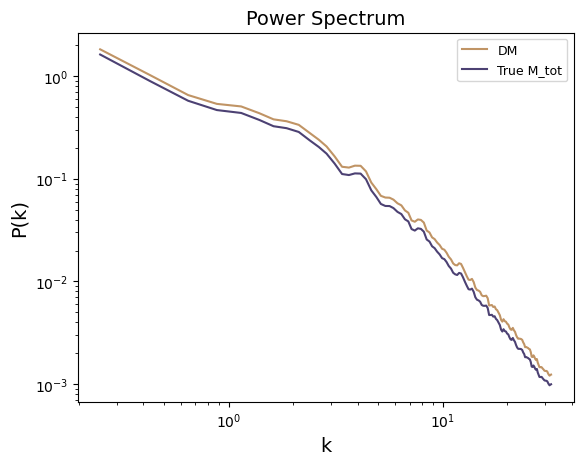

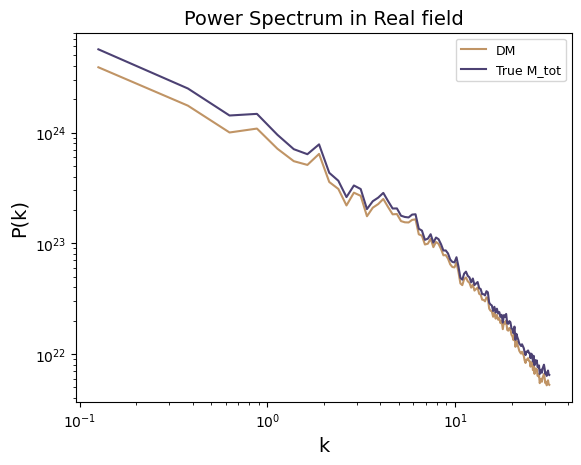

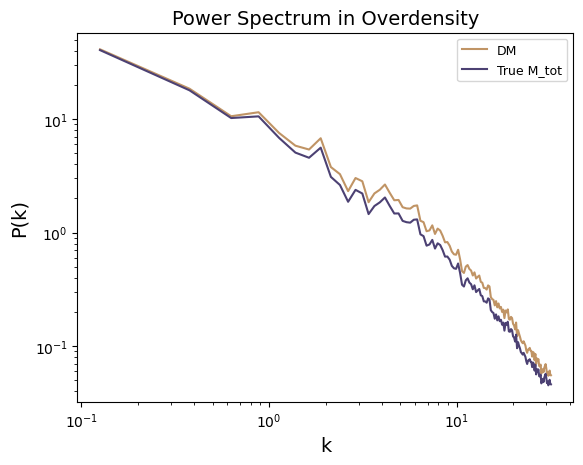

In [11]:
map_DM, x = next(iter(dm.train_dataloader()))
k, P = compute_pk(map_DM.cpu().numpy())
plt.figure()
plt.loglog(k, P, label="DM", color='#c09465')
k, P = compute_pk((map_DM+x).cpu().numpy())
plt.loglog(k, P, label="True M_tot", color='#4c4173')
plt.legend(fontsize=9)
plt.xlabel('k',fontsize=14)
plt.ylabel('P(k)',fontsize=14)
plt.title("Power Spectrum", fontsize=14)
print(map_DM.sum(), (map_DM+x).sum())


map_DM, x = next(iter(dm.train_dataloader()))
map_DM = map_DM[0].cpu().numpy().reshape([256,256])
x = x[0].cpu().numpy().reshape([256,256])
#map_DM = map_DM/map_DM.mean() - 1
map_hydro = map_DM+x
#map_hydro = map_hydro/map_hydro.mean() - 1
box_size = 25
k, P = power_spectrum(map_DM, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
plt.figure()
plt.loglog(k, P, label="DM", color='#c09465')
k, P = power_spectrum(map_hydro, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))

plt.loglog(k, P, label="True M_tot", color='#4c4173')
plt.legend(fontsize=9)
plt.xlabel('k',fontsize=14)
plt.ylabel('P(k)',fontsize=14)
plt.title("Power Spectrum in Real field", fontsize=14)
print(map_DM.sum(), (map_DM+x).sum())


map_DM = map_DM/map_DM.mean() - 1
map_hydro = map_hydro/map_hydro.mean() - 1
box_size = 25
k, P = power_spectrum(map_DM, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
plt.figure()
plt.loglog(k, P, label="DM", color='#c09465')
k, P = power_spectrum(map_hydro, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
plt.loglog(k, P, label="True M_tot", color='#4c4173')
plt.legend(fontsize=9)
plt.xlabel('k',fontsize=14)
plt.ylabel('P(k)',fontsize=14)
plt.title("Power Spectrum in Overdensity", fontsize=14)
print(map_DM.sum(), (map_DM+x).sum())


In [30]:
print(map_DM.shape)

(256, 256)


In [13]:
print(np.shape(dm.train_data))
def get_mean_std(data):
    x_s = []
    y_s = []
    for d in data:
        x, y = d
        x_s.append(x)
        y_s.append(y)
    mean_x = np.array(x_s).mean()
    std_x = np.array(x_s).std()
    mean_y = np.array(y_s).mean()
    std_y = np.array(y_s).std()
    print(mean_x, std_x, mean_y, std_y)
get_mean_std(dm.train_data)

(12000, 2, 1, 256, 256)
349026730308.4211 3360607218701.9375 68007528871.347145 391409741471.2632


/tmp/ipykernel_323153/1714318986.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(conditioning[0].squeeze().cpu() + 1))#, vmin=-2, vmax=5)


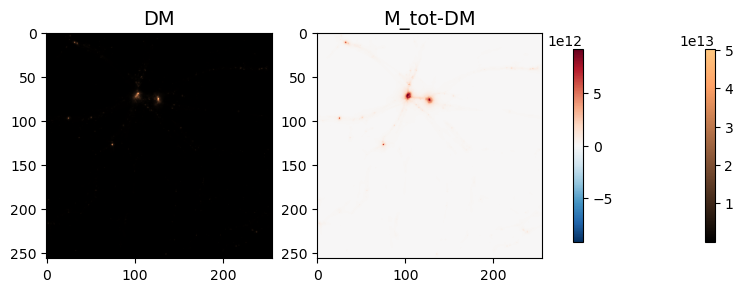

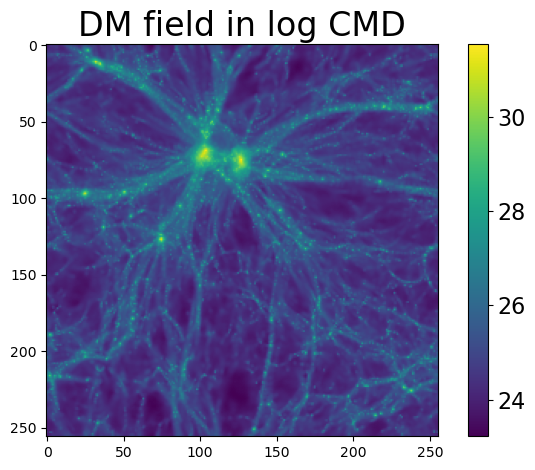

tensor(1.3671e+11)


In [12]:
one_batch = next(iter(dm.train_dataloader()))
conditioning, target = one_batch
fig, ax = plt.subplots(1,2,figsize=(10,5))   
im0 = ax.flat[0].imshow(conditioning[0].squeeze().cpu(), cmap='copper') #, vmin=-.1, vmax=11)
im1 = ax.flat[1].imshow(target[0].squeeze().cpu(), cmap='RdBu_r', norm=colors.CenteredNorm()) #, vmin=-2, vmax=6)
ax.flat[0].set_title("DM", fontsize=14)
ax.flat[1].set_title("M_tot-DM", fontsize=14)
fig.colorbar(im0, ax=ax.ravel().tolist(), shrink=0.5)
fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.5)

plt.figure()
plt.imshow(np.log(conditioning[0].squeeze().cpu() + 1))#, vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field in log CMD', fontsize=24)
plt.tight_layout()
plt.show()
print(conditioning[0].squeeze().cpu().mean())

/tmp/ipykernel_310768/3162015341.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(transformed_conditioning[0].squeeze().cpu() + 1))#, vmin=-2, vmax=5)


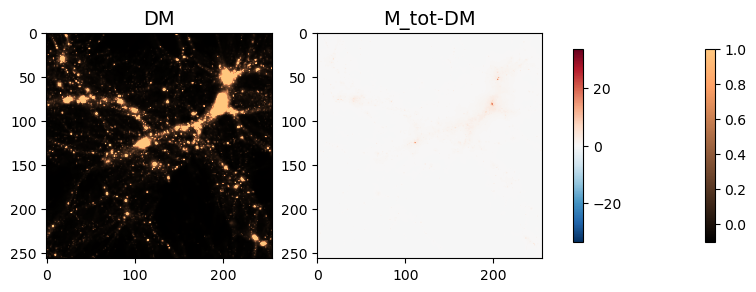

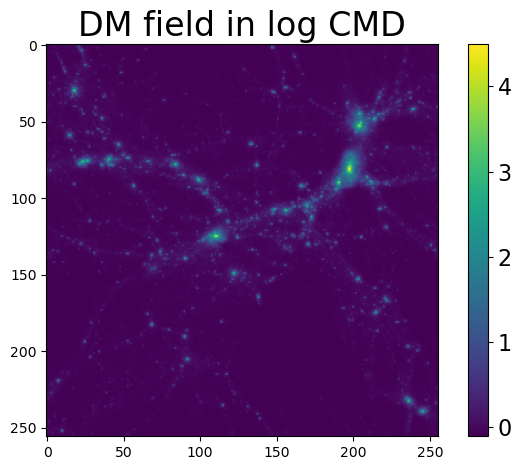

tensor(0.0499)


In [18]:
transformed_conditioning, transformed_target = norm(one_batch)
fig, ax = plt.subplots(1,2,figsize=(10,5))   
im0 = ax.flat[0].imshow(transformed_conditioning[0].squeeze().cpu(), cmap='copper', vmin=-.1, vmax=1)
im1 = ax.flat[1].imshow(transformed_target[0].squeeze().cpu(), cmap='RdBu_r', norm=colors.CenteredNorm()) #, vmin=-2, vmax=6)
ax.flat[0].set_title("DM", fontsize=14)
ax.flat[1].set_title("M_tot-DM", fontsize=14)
fig.colorbar(im0, ax=ax.ravel().tolist(), shrink=0.5)
fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.5)
plt.figure()
plt.imshow(np.log(transformed_conditioning[0].squeeze().cpu() + 1))#, vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field in log CMD', fontsize=24)
plt.tight_layout()
plt.show()
print(transformed_conditioning[0].squeeze().cpu().mean())

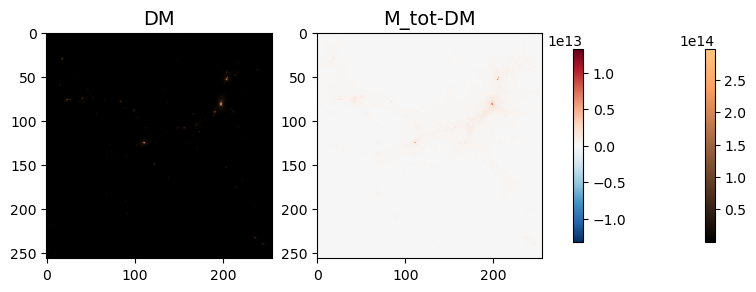

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,5)) 
transformed_conditioning_, transformed_target_ = norm.inverse_transform([transformed_conditioning, transformed_target])
im0 = ax.flat[0].imshow(transformed_conditioning_[0].squeeze().cpu(), cmap='copper') #, vmin=-.1, vmax=11)
im1 = ax.flat[1].imshow(transformed_target_[0].squeeze().cpu(), cmap='RdBu_r', norm=colors.CenteredNorm()) #, vmin=-2, vmax=6)
ax.flat[0].set_title("DM", fontsize=14)
ax.flat[1].set_title("M_tot-DM", fontsize=14)
fig.colorbar(im0, ax=ax.ravel().tolist(), shrink=0.5)
fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.5)

In [8]:
print(target[0].mean(),transformed_target[0].mean())
print(target[0].std(),transformed_target[0].std())

tensor(9.4957e+10) tensor(0.0689)
tensor(5.7352e+11) tensor(1.4653)


In [9]:
print(conditioning[0].mean(),transformed_conditioning[0].mean())
print(conditioning[0].std(),transformed_conditioning[0].std())

tensor(7.2935e+11) tensor(0.1132)
tensor(5.1203e+12) tensor(1.5236)


In [21]:
'''
Check if reverse transformation is correct
'''
conditioning[0].squeeze().cpu() == transformed_conditioning_[0].squeeze().cpu()

tensor([[ True,  True, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True]])

In [ ]:
print(conditioning[0])
print(target[0]) #Looks like residual field is only 10 times lower than DM

In [4]:
dm_transformed = get_astro_data(
        num_workers=8,
        batch_size=12,
        dataset= 'Astrid'
    )

In [31]:
one_batch = next(iter(dm_transformed.train_dataloader()))
conditioning, target = one_batch
print(conditioning.device)

cpu


/tmp/ipykernel_989810/3960175525.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(conditioning[0].squeeze().cpu()), cmap='cividis', vmin=-2, vmax=5)


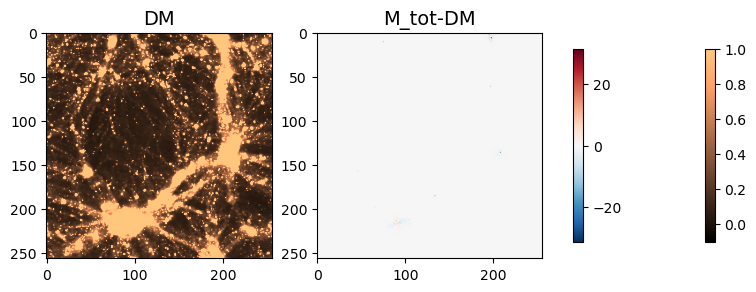

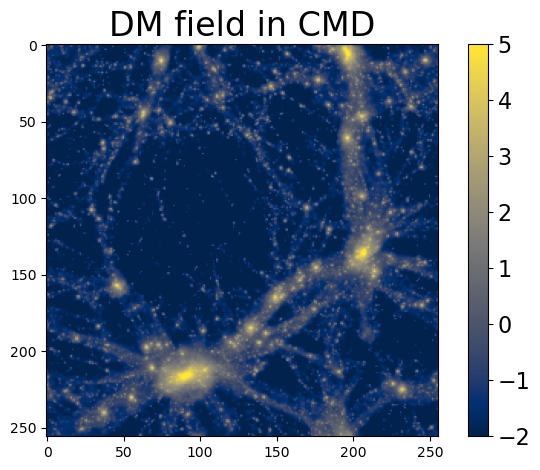

/tmp/ipykernel_989810/3960175525.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(conditioning[0].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


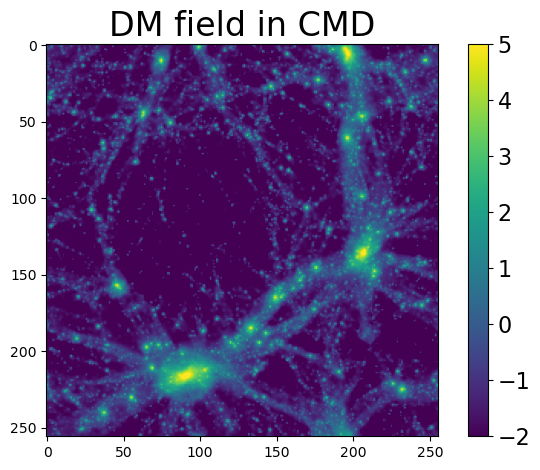

/tmp/ipykernel_989810/3960175525.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(target[0]+conditioning[0]).squeeze().cpu(), cmap='copper', vmin=-2, vmax=5)


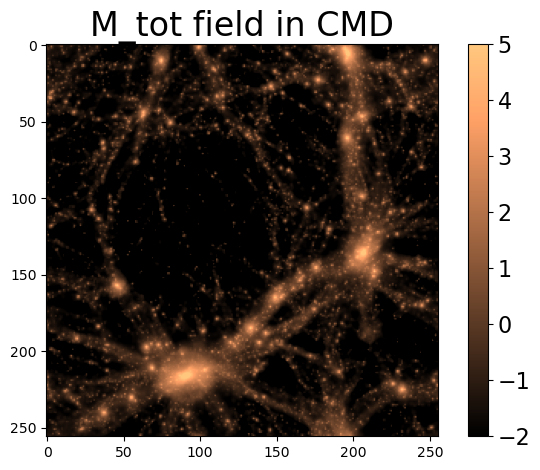

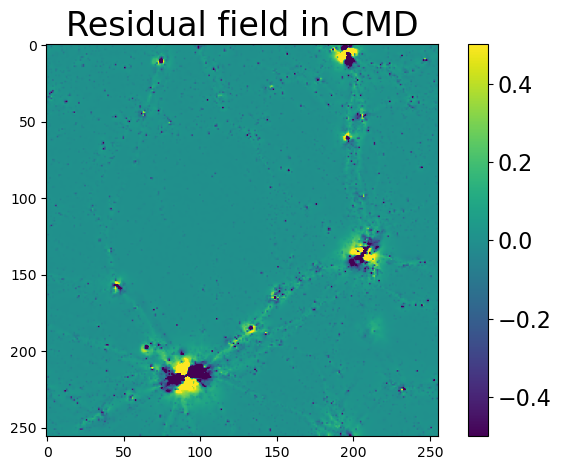

tensor(1.) tensor(8.0297)
tensor(-7.0473e-19) tensor(0.2904)
tensor(1.) tensor(7.8671)


In [5]:
'''
Testing colorbar
'''

one_batch = next(iter(dm_transformed.train_dataloader()))
conditioning, target = one_batch
fig, ax = plt.subplots(1,2,figsize=(10,5))   
im0 = ax.flat[0].imshow(conditioning[0].squeeze().cpu(), cmap='copper', vmin=-.1, vmax=1)
im1 = ax.flat[1].imshow(target[0].squeeze().cpu(), cmap='RdBu_r', norm=colors.CenteredNorm()) #,  vmin=-2, vmax=2)
ax.flat[0].set_title("DM", fontsize=14)
ax.flat[1].set_title("M_tot-DM", fontsize=14)
fig.colorbar(im0, ax=ax.ravel().tolist(), shrink=0.5)
fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.5)

plt.figure()
plt.imshow(np.log(conditioning[0].squeeze().cpu()), cmap='cividis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field in CMD', fontsize=24)
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(np.log(conditioning[0].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field in CMD', fontsize=24)
plt.tight_layout()
plt.show()


plt.figure()
plt.imshow(np.log(target[0]+conditioning[0]).squeeze().cpu(), cmap='copper', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('M_tot field in CMD', fontsize=24)
plt.tight_layout()
plt.show()
plt.figure()
plt.imshow(target[0].squeeze().cpu(), cmap='viridis', vmin=-0.5, vmax=0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Residual field in CMD', fontsize=24)
plt.tight_layout()
plt.show()

print(conditioning[0].mean(),conditioning[0].std())
print(target[0].mean(),target[0].std())
print((target[0]+conditioning[0]).mean(),(target[0]+conditioning[0]).std())

In [6]:
def print_mean_std(sim_ind):
    print(conditioning[sim_ind].mean(),conditioning[sim_ind].std())
    print(target[sim_ind].mean(),target[sim_ind].std())
    print((target[sim_ind]+conditioning[sim_ind]).mean(),(target[sim_ind]+conditioning[sim_ind]).std())
print_mean_std(10)
print_mean_std(5)


tensor(1.) tensor(7.1429)
tensor(-2.6563e-18) tensor(0.3348)
tensor(1.) tensor(6.8804)
tensor(1.) tensor(6.1486)
tensor(-1.5179e-18) tensor(0.3172)
tensor(1.) tensor(5.9383)


Text(0.5, 1.0, 'Power Spectrum')

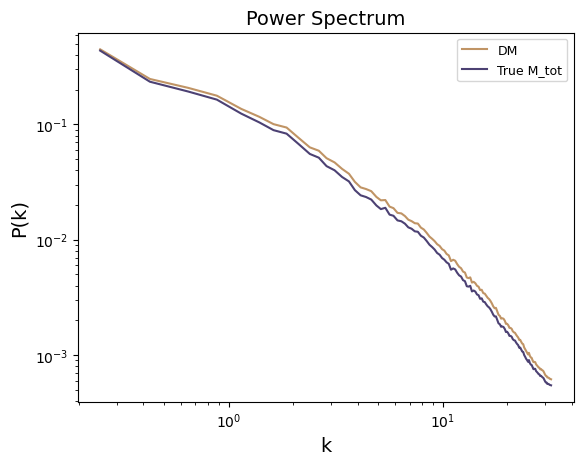

In [28]:
conditioning, target = next(iter(dm_transformed.train_dataloader()))
norm = Normalize('Astrid')
#map_DM, x = norm.inverse_transform([conditioning, target])
k, P = compute_pk(conditioning.cpu().numpy())
plt.loglog(k, P, label="DM", color='#c09465')
k, P = compute_pk((conditioning+target).cpu().numpy())
plt.loglog(k, P, label="True M_tot", color='#4c4173')
plt.legend(fontsize=9)
plt.xlabel('k',fontsize=14)
plt.ylabel('P(k)',fontsize=14)
plt.title("Power Spectrum", fontsize=14)